In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np

Instructions for updating:
non-resource variables are not supported in the long term


수학적인 공식을 이용해 선형회귀를 풀어내는 방법부터 텐서플로우의 패러다임을 이용해 일반적인 선형회귀와 그 변형 방법들을 수행해볼 것임

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import pandas as pd

# Using the matrix inverse method
이차원의 선형 회귀에 대해 역행렬 방법을 사용<br>
$Ax = b$<br>
$x$ = ${(A^{T}A)}^{-1}A^{T}b$

In [7]:
# 1.
sess = tf.Session()
x_vals = np.linspace(0,10,100)
y_vals = x_vals + np.random.normal(0,1,100)

In [23]:
# 2.
x_vals_column = np.transpose(np.matrix(x_vals))
# 상수항
one_column = np.transpose(np.matrix(np.repeat(1,100)))
A = np.column_stack((x_vals_column,one_column))
b = np.transpose(np.matrix(y_vals))

In [25]:
# 3. A와 b를 텐서로
A_tensor = tf.constant(A)
b_tensor = tf.constant(b)

# 4. 수식 정의
tA_A = tf.matmul(tf.transpose(A_tensor),A_tensor)
tA_A_inv = tf.matrix_inverse(tA_A)
product = tf.matmul(tA_A_inv,tf.transpose(A_tensor))
solution = tf.matmul(product,b_tensor)
solution_eval = sess.run(solution)

In [26]:
# 5. coefficients 추출
slope = solution_eval[0][0]
y_intercept = solution_eval[1][0]
print('slope : '+str(slope))
print('y_intercept : '+str(y_intercept))

slope : 1.01185105742357
y_intercept : -0.1668922657687122


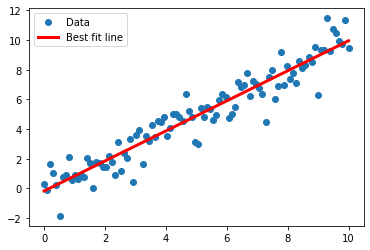

In [28]:
best_fit=[]
for i in x_vals:
    best_fit.append(slope*i+y_intercept)
    
plt.plot(x_vals,y_vals,'o',label='Data')
plt.plot(x_vals,best_fit,'r-',label='Best fit line',linewidth=3)
plt.legend(loc='upper left')

# Implementing a decompostion method
행렬 분해를 사용, 특히 그중에서도 텐서플로우에 관련 함수가 내장된 Cholesky 분해를 사용

Cholesky 분해는 행렬을 서로가 전치 관계인 상삼각행렬, 하삼각행렬로 분해한다.$A=LL^T$($L$은 하삼각행렬,대각성분은 모두 양의 실수)

단계) $Ax=b$
1. $LL^{T}x=b$
2. $Ly = b$
3. $L^{T}x = y$

In [2]:
# 1.
sess = tf.Session()
x_vals = np.linspace(0,10,100)
y_vals = x_vals + np.random.normal(0,1,100)
x_vals_column = np.transpose(np.matrix(x_vals))
one_column = np.transpose(np.matrix(np.repeat(1,100)))
A = np.c_[x_vals_column,one_column]
b = np.transpose(np.matrix(y_vals))
A_tensor = tf.constant(A)
b_tensor = tf.constant(b)

In [3]:
# 2. Cholesky decomposition of (A^T)A
# 그 이유는 행렬을 이용한 선형회귀 공식 생각
tA_A = tf.matmul(tf.transpose(A_tensor),A_tensor)
L = tf.cholesky(tA_A)
tA_b = tf.matmul(tf.transpose(A_tensor),b)
# Ly = b
sol1 = tf.matrix_solve(L,tA_b)
# L^T x = y
sol2 = tf.matrix_solve(tf.transpose(L),sol1)

In [7]:
tA_A.eval(session = tf.Session())

array([[3350.16835017,  500.        ],
       [ 500.        ,  100.        ]])

In [8]:
L.eval(session=tf.Session())

array([[57.88063882,  0.        ],
       [ 8.6384672 ,  5.03754746]])

In [10]:
sess.run(tf.matmul(L,tf.transpose(L)))

array([[3350.16835017,  500.        ],
       [ 500.        ,  100.        ]])

In [41]:
# 3. 계수 추출
solution_eval = sess.run(sol2)
slope = solution_eval[0,0]
y_intercept = solution_eval[1,0]
print('기울기 : {}, y절편 : {}'.format(slope,y_intercept))

기울기 : 0.9925198173505693, y절편 : -0.11497070728628721


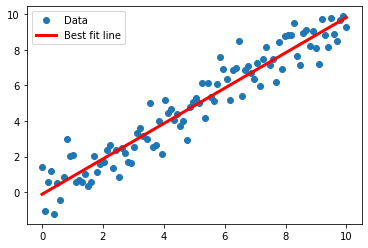

In [42]:
# 4.
best_fit = []
for i in x_vals:
    best_fit.append(slope*i+y_intercept)
plt.plot(x_vals,y_vals,'o',label='Data')
plt.plot(x_vals,best_fit,'r-',label='Best fit line',linewidth=3)
plt.legend(loc='upper left')

매우 큰 사이즈의 데이터에 대해서 이와 같이 효율적이고 수치적으로 안정된 방법을 채택할 수 있다.

# Learninig the TensorFlow way of linear regression
비록 수치적 방법과 행렬 분해의 방법은 매우  강력하지만 텐서플로우는 계수와 절편을 찾는데 있어서 또 다른 방법을 가지고 있다.<br>
텐서플로우는 반복적으로, 점진적으로 loss를 최소화하는 최상의 파라미터를 학습해나간다.

이 방법에서 배치 사이즈의 데이터 포인트들을 통해 텐서플로우는 계수, 절편을 업데이트한다. iris 데이터를 가지고 확인해보도록 한다.

In [12]:
# x : petal width, y : sepal length 

# 1.
from sklearn.datasets import load_iris
iris = load_iris()
import pandas as pd
iris_df = pd.DataFrame(iris.data, columns = iris.feature_names)
x_vals = iris_df.iloc[:,3].values
y_vals = iris_df.iloc[:,0].values

In [13]:
# 2. 
learning_rate = 0.05
batch_size = 25
x_data = tf.placeholder(shape=[None,1],dtype=tf.float32)
y_target = tf.placeholder(shape=[None,1],dtype=tf.float32)
A = tf.Variable(tf.random_normal(shape=[1,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# 3. 
model_output = tf.add(tf.matmul(x_data,A),b)

In [14]:
# 4. loss 함수를 L2 norm으로 정의한다.
loss = tf.reduce_mean(tf.square(y_target - model_output))
init = tf.global_variables_initializer()

my_opt = tf.train.GradientDescentOptimizer(learning_rate)
train_step = my_opt.minimize(loss)

In [15]:
# 5.
sess.run(init)

loss_vec = []
for i in range(100):
    rand_index = np.random.choice(len(x_vals),size=batch_size)
    rand_x = x_vals[rand_index].reshape(-1,1)
    rand_y = y_vals[rand_index].reshape(-1,1)
    sess.run(train_step,feed_dict={x_data:rand_x,y_target:rand_y})
    temp_loss = sess.run(loss,feed_dict={x_data:rand_x,y_target:rand_y})
    loss_vec.append(temp_loss)
    if (i+1) % 25 ==0:
        print('Step #'+str(i+1)+' A = '+str(sess.run(A))+' b = '+str(sess.run(b)))
        print('Loss = '+str(temp_loss))

Step #25 A = [[2.412731]] b = [[2.5913937]]
Loss = 2.0309277
Step #50 A = [[1.7534993]] b = [[3.4999375]]
Loss = 1.0370908
Step #75 A = [[1.4079232]] b = [[3.987007]]
Loss = 0.3262006
Step #100 A = [[1.1981881]] b = [[4.27766]]
Loss = 0.29905623


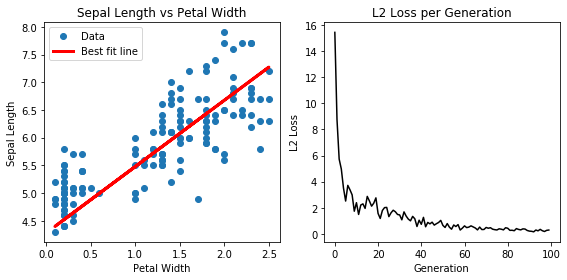

In [19]:
[slope] = sess.run(A)
[y_intercept] = sess.run(b)
best_fit = []
for i in x_vals:
    best_fit.append(slope*i+y_intercept)
    
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(x_vals,y_vals,'o',label='Data')
ax[0].plot(x_vals,best_fit,'r-',label='Best fit line',linewidth = 3)
ax[0].legend(loc='best')
ax[0].set_title('Sepal Length vs Petal Width')
ax[0].set_xlabel('Petal Width')
ax[0].set_ylabel('Sepal Length')

ax[1].plot(loss_vec,'k-')
ax[1].set_title('L2 Loss per Generation')
ax[1].set_xlabel('Generation')
ax[1].set_ylabel('L2 Loss')

fig.tight_layout()

최적의 line으로의 수렴은 반복의 횟수, 배치 사이즈, 학습률, loss 함수 등에 의존한다.<br>
시간 경과에 따른 loss 함수의 변화를 관찰하는 것은 언제나 좋은 시도로서 하이퍼파라미터 조정, 문제점 파악 등을 돕는 역할을 한다.

# Understanding loss function in linear regression
각각 L1, L2 loss 함수를 가질 때 선형회귀 식의 수렴에의 영향도를 체크하도록 한다.

In [52]:
# 1.
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns = iris.feature_names)

x_vals = iris_df.iloc[:,3].values
y_vals = iris_df.iloc[:,0].values

learning_rate = 0.4
iterations = 50
batch_size = 25
x_data = tf.placeholder(shape=[None,1],dtype=tf.float32)
y_target = tf.placeholder(shape=[None,1],dtype=tf.float32)
A = tf.Variable(tf.random_normal(shape=[1,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

model_output = tf.add(tf.matmul(x_data,A),b)

In [53]:
# 2. L1 함수
loss_l1 = tf.reduce_mean(tf.abs(y_target - model_output))

# 3. 
init = tf.global_variables_initializer()
my_opt_l1 = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
train_step_l1 = my_opt_l1.minimize(loss_l1)

loss_vec_l1=[]
sess.run(init)

for i in range(iterations):
    rand_index = np.random.choice(len(x_vals),size=batch_size)
    rand_x = x_vals[rand_index].reshape(-1,1)
    rand_y = y_vals[rand_index].reshape(-1,1)
    sess.run(train_step_l1,feed_dict={x_data:rand_x,y_target:rand_y})
    temp_loss_l1 = sess.run(loss_l1,feed_dict={x_data:rand_x,y_target:rand_y})
    loss_vec_l1.append(temp_loss_l1)
    if (i+1) % 25 ==0:
        print('Step #'+str(i+1)+' A = '+str(sess.run(A))+' b = '+str(sess.run(b)))
        print('Loss = '+str(temp_loss_l1))

Step #25 A = [[1.4120865]] b = [[4.093674]]
Loss = 0.5636161
Step #50 A = [[1.0808865]] b = [[4.7176743]]
Loss = 0.4022049


In [54]:
# 모든 코드는 이전과 동일
loss_l1 = tf.reduce_mean(tf.abs(y_target - model_output))
loss_l2 = tf.reduce_mean(tf.square(y_target - model_output))

# 3. 
init = tf.global_variables_initializer()
my_opt_l2 = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
train_step_l2 = my_opt_l1.minimize(loss_l2)

loss_vec_l2=[]
sess.run(init)

for i in range(iterations):
    rand_index = np.random.choice(len(x_vals),size=batch_size)
    rand_x = x_vals[rand_index].reshape(-1,1)
    rand_y = y_vals[rand_index].reshape(-1,1)
    sess.run(train_step_l2,feed_dict={x_data:rand_x,y_target:rand_y})
    temp_loss_l2 = sess.run(loss_l2,feed_dict={x_data:rand_x,y_target:rand_y})
    loss_vec_l2.append(temp_loss_l2)
    if (i+1) % 25 ==0:
        print('Step #'+str(i+1)+' A = '+str(sess.run(A))+' b = '+str(sess.run(b)))
        print('Loss = '+str(temp_loss_l2))

Step #25 A = [[700.35455]] b = [[541.427]]
Loss = 1756726.4
Step #50 A = [[-55059.234]] b = [[-25865.484]]
Loss = 9329006000.0


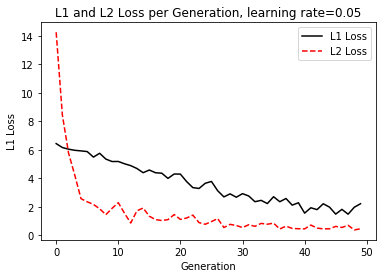

In [51]:
plt.plot(loss_vec_l1,'k-',label='L1 Loss')
plt.plot(loss_vec_l2,'r--',label='L2 Loss')
plt.title('L1 and L2 Loss per Generation, learning rate={}'.format(learning_rate))
plt.xlabel('Generation')
plt.ylabel("L1 Loss")
plt.legend(loc='best')

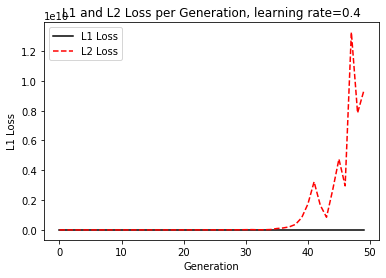

In [55]:
plt.plot(loss_vec_l1,'k-',label='L1 Loss')
plt.plot(loss_vec_l2,'r--',label='L2 Loss')
plt.title('L1 and L2 Loss per Generation, learning rate={}'.format(learning_rate))
plt.xlabel('Generation')
plt.ylabel("L1 Loss")
plt.legend(loc='best')

학습률 0.05에서는 더 낮은 값으로 잘 수렴하기에 l2 loss 함수가 더 선호된다.<br>
학습률 0.4에서는 L2는 발산하지만 반면에 L1은 수렴한다.

# Implementing deming regression
좀 다른 방식으로 model line과 데이터 포인터 간의 거리를 측정하도록 한다.<br>
deming regression은 몇가지 다른 이름으로 불리는데 total regression, orthogonal distance regression(ODR), shortest-distance regression 등이다.

일반적인 least square 선형회귀가 수직적인 거리를 최소화하는 것이라면 deming regression은 line으로의 거리를 최소화한다. deming regression을 수행하기 위해서는 loss 함수를 수정해야한다. line과 포인트 간의 수직 거리를 계산하는 방법은 공식으로 알려져 있는데 이를 텐서플로우 방식으로 수행하도록 한다.

In [149]:
# 1.
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns = iris.feature_names)

x_vals = iris_df.iloc[:,3].values
y_vals = iris_df.iloc[:,0].values

batch_size = 50
learning_rate = 0.1

x_data = tf.placeholder(shape=[None,1],dtype=tf.float32)
y_target = tf.placeholder(shape=[None,1],dtype=tf.float32)
A = tf.Variable(tf.random_normal(shape=[1,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

model_output = tf.add(tf.matmul(x_data,A),b)

$d = {{|y_0 - (mx_0 + b)|} \over {\sqrt{m^2+1}}}$
<br>for $ y = mx+b$

In [150]:
# loss 함수 정의
deming_numerator = tf.abs(tf.subtract(y_target,tf.add(tf.matmul(x_data,A),b)))
deming_denominator = tf.sqrt(tf.add(tf.square(A),1))
loss = tf.reduce_mean(tf.truediv(deming_numerator,deming_denominator))

In [151]:
# 3.
init = tf.global_variables_initializer()
sess.run(init)
my_opt = tf.train.GradientDescentOptimizer(learning_rate)
train_step = my_opt.minimize(loss)

loss_vec = []
for i in range(400):
    rand_index = np.random.choice(len(x_vals),size=batch_size)
    rand_x = x_vals[rand_index].reshape(-1,1)
    rand_y = y_vals[rand_index].reshape(-1,1)
    sess.run(train_step, feed_dict = {x_data:rand_x,y_target:rand_y})
    temp_loss = sess.run(loss,feed_dict={x_data:rand_x,y_target:rand_y})
    loss_vec.append(temp_loss)
    
    if (i+1)%50 == 0:
        print('Step # {} A = {}, b = {}'.format(i+1,sess.run(A),sess.run(b)))
        print('Loss = {}'.format(temp_loss))

Step # 50 A = [[3.3000953]], b = [[1.1587678]]
Loss = 0.5043794512748718
Step # 100 A = [[3.3200476]], b = [[1.3629982]]
Loss = 0.44300171732902527
Step # 150 A = [[3.2312593]], b = [[1.4896708]]
Loss = 0.4109637141227722
Step # 200 A = [[3.1320078]], b = [[1.6199594]]
Loss = 0.40111908316612244
Step # 250 A = [[3.033632]], b = [[1.7633489]]
Loss = 0.5141685009002686
Step # 300 A = [[2.9734232]], b = [[1.9325832]]
Loss = 0.42856696248054504
Step # 350 A = [[2.874579]], b = [[2.0778084]]
Loss = 0.4150766134262085
Step # 400 A = [[2.7607589]], b = [[2.2272906]]
Loss = 0.3936412036418915


Text(0, 0.5, 'sepal length')

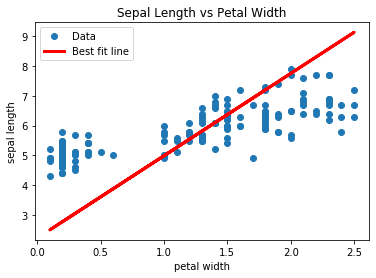

In [152]:
[slope] = sess.run(A)
[y_intercept] = sess.run(b)
best_fit = []
for i in x_vals:
    best_fit.append(slope*i + y_intercept)

plt.plot(x_vals,y_vals,'o',label='Data')
plt.plot(x_vals,best_fit,'r-',label='Best fit line',linewidth=3)
plt.legend(loc='best')
plt.title('Sepal Length vs Petal Width')
plt.xlabel('petal width')
plt.ylabel('sepal length')

In [161]:
A = np.c_[x_vals,np.repeat(1,len(x_vals))]
b = y_vals
np.linalg.inv(np.transpose(A).dot(A)).dot(np.transpose(A)).dot(b)

array([0.88858025, 4.77762942])

# Implementing lasso and ridge regression
계수를 규제하기 위해 규제항(regularization term)을 넣는다. 몇가지 이유가 있는데 가장 일반적인 이유는 의존 변수에 영향을 행사하는 특징들을 제한하기 위해서이다. 이는 loss 함수에 항을 하나 추가함으로서 구현할 수 있다.

lasso 회귀의 경우 경사항(A)이 특정 값을 갖게 되었을 때 loss 함수를 매우 많이 증가시키는 항을 추가한다. 텐서플로우의 논리적인 연산을 이용할 수 있으나 그것과 관련된 기울기는 갖지 않는다. 대신 계단함수에 근사하는 연속함수(called continuous heavy step function) 를 이용한다. 그 값은 우리가 선택한 정규화 컷오프까지의 스케일을 갖는다.

ridge 회귀의 경우 L2 norm 항을 추가한다.

In [181]:
# 1.
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns = iris.feature_names)

x_vals = iris_df.iloc[:,3].values
y_vals = iris_df.iloc[:,0].values

batch_size = 50
learning_rate = 0.001

x_data = tf.placeholder(shape=[None,1],dtype=tf.float32)
y_target = tf.placeholder(shape=[None,1],dtype=tf.float32)
A = tf.Variable(tf.random_normal(shape=[1,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

model_output = tf.add(tf.matmul(x_data,A),b)

In [182]:
# 2. heavyside step function
# lasso 회귀의 컷오프를 0.9로 사용한다.

lasso_param = tf.constant(0.9)
heavyside_step = tf.truediv(1.,tf.add(1.,tf.exp(tf.multiply(-100.,tf.subtract(A,lasso_param)))))

regularization_param = tf.multiply(heavyside_step,99.)

loss = tf.add(tf.reduce_mean(tf.square(y_target - model_output)),regularization_param)

In [183]:
# 3.
init = tf.global_variables_initializer()
my_opt = tf.train.GradientDescentOptimizer(learning_rate)
train_step = my_opt.minimize(loss)

In [185]:
# 4.
sess.run(init)

loss_vec = []
for i in range(1500):
    rand_index = np.random.choice(len(x_vals),size=batch_size)
    rand_x = x_vals[rand_index].reshape(-1,1)
    rand_y = y_vals[rand_index].reshape(-1,1)
    sess.run(train_step, feed_dict = {x_data:rand_x,y_target:rand_y})
    temp_loss = sess.run(loss,feed_dict={x_data:rand_x,y_target:rand_y})
    loss_vec.append(temp_loss[0])
    
    if (i+1)%300 == 0:
        print('Step # {} A = {}, b = {}'.format(i+1,sess.run(A),sess.run(b)))
        print('Loss = {}'.format(temp_loss))

Step # 300 A = [[0.83072144]], b = [[0.9472949]]
Loss = [[15.977933]]
Step # 600 A = [[0.8242452]], b = [[2.7054436]]
Loss = [[4.901698]]
Step # 900 A = [[0.8187818]], b = [[3.6767075]]
Loss = [[1.6493381]]
Step # 1200 A = [[0.81333005]], b = [[4.2159605]]
Loss = [[0.7396133]]
Step # 1500 A = [[0.8081369]], b = [[4.5138125]]
Loss = [[0.33051082]]


너무 큰 스텝사이즈는 수렴하지 않을 수 있다.

In [ ]:
# ridge regression
ridge_param = tf.constant(1.)
ridge_loss = tf.reduce_mean(tf.sqaure(A))
loss = tf.expand_dims(tf.add(tf.reduce_mean(tf.square(y_target - model_output)),tf.multiply(ridge_param,ridge_loss)),0)

# Implementing elastic net regression
L1과 L2 규제 term을 loss 함수에 추가함으로서 lasso와 ridge 회귀를 결합한 형태이다.

In [4]:
# 1. iris 데이터셋을 이용
import pandas as pd
from sklearn.datasets import load_iris
iris = load_iris()
iris_df = pd.DataFrame(iris.data,columns=iris.feature_names)

In [17]:
sess = tf.Session()

In [9]:
# 2.
x_vals = iris_df.iloc[:,1:].values
y_vals = iris_df.iloc[:,0].values

In [15]:
# 3.
batch_size=50
learning_rate = 0.001
x_data = tf.placeholder(shape=[None,3],dtype=tf.float32)
y_target = tf.placeholder(shape=[None,1],dtype=tf.float32)
A = tf.Variable(tf.random_normal(shape=[3,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

model_output = tf.add(tf.matmul(x_data,A),b)

In [16]:
elastic_params1 = tf.constant(1.)
elastic_params2 = tf.constant(1.)
l1_a_loss = tf.reduce_mean(tf.abs(A))
l2_a_loss = tf.reduce_mean(tf.square(A))
e1_term = tf.multiply(elastic_params1,l1_a_loss)
e2_term = tf.multiply(elastic_params2,l2_a_loss)
loss = tf.expand_dims(tf.add(tf.add(tf.reduce_mean(tf.square(y_target-model_output)),e1_term),e2_term),0)

In [19]:
# 5.
init = tf.global_variables_initializer()
sess.run(init)
my_opt = tf.train.GradientDescentOptimizer(learning_rate)
train_step = my_opt.minimize(loss)
loss_vec = []
for i in range(1000):
    rand_index = np.random.choice(len(x_vals),size=batch_size)
    rand_x = x_vals[rand_index].reshape(-1,3)
    rand_y = y_vals[rand_index].reshape(-1,1)
    sess.run(train_step,feed_dict={x_data:rand_x,y_target:rand_y})
    temp_loss = sess.run(loss,feed_dict={x_data:rand_x,y_target:rand_y})
    loss_vec.append(temp_loss)
    if (i+1)%250 == 0:
        print('Step # {} A = {}, b = {}'.format(i+1,sess.run(A),sess.run(b)))
        print('Loss = {}'.format(temp_loss))

Step # 250 A = [[ 0.37598005]
 [ 0.86029816]
 [-0.14379677]], b = [[1.3683242]]
Loss = [1.2236863]
Step # 500 A = [[ 0.5839785 ]
 [ 0.666327  ]
 [-0.08183318]], b = [[1.4745755]]
Loss = [0.9132575]
Step # 750 A = [[6.5191853e-01]
 [5.7450098e-01]
 [2.4037375e-04]], b = [[1.5518327]]
Loss = [0.8147964]
Step # 1000 A = [[6.7620075e-01]
 [5.3980750e-01]
 [2.4869913e-04]], b = [[1.6209438]]
Loss = [0.79669183]


Text(0, 0.5, 'Loss')

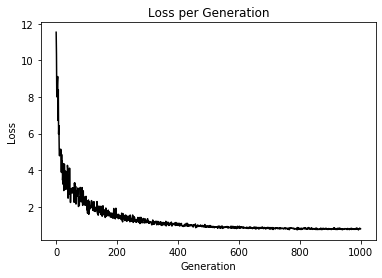

In [20]:
plt.plot(loss_vec,'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')

규제는 loss 함수에 적절한 항을 추가해주는 간단한 방식으로 이뤄진다.

# Implementing logistic regression
로지스틱 회귀는 선형 모델을 이진 분류 문제 해결을 위해 약간 변형한 방식이다. 선형 output을 0과 1사이의 값을 갖는 sigmoid 함수에 넣는 방식으로 이뤄진다. 타겟은 0과 1 둘 중 하나이므로 함수의 결과 값이 일정 컷오프 이상이면 1, 이하이면 0으로 분류하는 방식을 취한다.

컷오프는 0.5로 정하고 낮은 출산율을 예측하는 데이터를 이용해 실습해보도록 한다.

In [13]:
# 1.2.
df = pd.read_excel('birth.xlsx')
x_vals = df.iloc[:,1:8].values
y_vals = df.iloc[:,0].values

# 3.
train_indices = np.random.choice(len(x_vals),round(len(x_vals)*0.8),replace=False)
test_indices = np.array(list(set(range(len(x_vals)))-set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

# 4.scaling(로지스틱 회귀는 특성들이 0~1 사이일 때 잘 작동한다.)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x_vals_train)
x_vals_train_scaled = scaler.transform(x_vals_train)
x_vals_test_scaled = scaler.transform(x_vals_test)

# 테스트셋은 훈련에 아무 영향도 미치지 않게 하는게 중요

In [14]:
# 5.
batch_size = 25
x_data = tf.placeholder(shape=[None,7],dtype=tf.float32)
y_target = tf.placeholder(shape=[None,1],dtype=tf.float32)
A = tf.Variable(tf.random_normal(shape=[7,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))
model_output = tf.add(tf.matmul(x_data,A),b)

# 6. loss 함수를 정의
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits = model_output,labels = y_target))
init = tf.global_variables_initializer()
my_opt = tf.train.GradientDescentOptimizer(0.01)
train_step = my_opt.minimize(loss)

# 7. loss 함수를 따라 분류의 정확도를 기록한다.
prediction = tf.round(tf.sigmoid(model_output))
predictions_correct = tf.cast(tf.equal(prediction,y_target),tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

In [15]:
# 7. loss 함수를 따라 분류의 정확도를 기록한다.
prediction = tf.round(tf.sigmoid(model_output))
predictions_correct = tf.cast(tf.equal(prediction,y_target),tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

In [16]:
sess = tf.Session()

In [17]:
# 8. 
sess.run(init)
loss_vec = []
train_acc = []
test_acc = []
for i in range(1500):
    rand_index = np.random.choice(len(x_vals_train),size=batch_size)
    rand_x = x_vals_train_scaled[rand_index].reshape(-1,7)
    rand_y = y_vals_train[rand_index].reshape(-1,1)
    sess.run(train_step,feed_dict = {x_data:rand_x, y_target:rand_y})
    temp_loss = sess.run(loss,feed_dict={x_data:rand_x, y_target:rand_y})
    loss_vec.append(temp_loss)
    
    temp_acc_train = sess.run(accuracy,feed_dict={x_data:x_vals_train_scaled.reshape(-1,7),y_target:y_vals_train.reshape(-1,1)})
    train_acc.append(temp_acc_train)
    
    temp_acc_test = sess.run(accuracy,feed_dict={x_data:x_vals_test_scaled.reshape(-1,7),y_target:y_vals_test.reshape(-1,1)})
    test_acc.append(temp_acc_test)

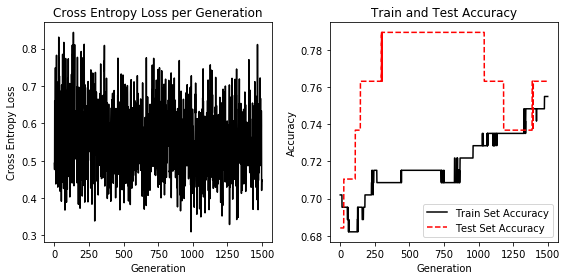

In [18]:
# 9.
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(loss_vec,'k-')
ax[0].set_title('Cross Entropy Loss per Generation')
ax[0].set_xlabel('Generation')
ax[0].set_ylabel('Cross Entropy Loss')

ax[1].plot(train_acc,'k-',label='Train Set Accuracy')
ax[1].plot(test_acc,'r--',label='Test Set Accuracy')
ax[1].set_title('Train and Test Accuracy')
ax[1].set_xlabel('Generation')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()